# CHURN PREDICTION MODEL

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
)

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm
import time

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

from pathlib import Path

import unimib_snowit_project.utils as u

# Load Datasets

In [2]:
root_dir_path = u.get_root_dir()
df_in_dir = "data_loaded"
data_pkl_dir_path = root_dir_path.joinpath(df_in_dir)


pkl_files = [
    'users.pkl',
    'profiles.pkl',
    'cards.pkl',
    'orders.pkl',
    'order_details.pkl',
]

pkl_paths = {file_name.split('.')[0]: data_pkl_dir_path.joinpath(file_name) for file_name in pkl_files}

dfs = {}

for name, path in pkl_paths.items():
    dfs[name] = pd.read_pickle(path)
    print(f"{name} loaded: {dfs[name].shape[0]} rows, {dfs[name].shape[1]} columns")


users_df = dfs['users']
profiles_df = dfs['profiles']
cards_df = dfs['cards']
orders_df = dfs['orders']   
order_details_df = dfs['order_details']

users loaded: 728598 rows, 14 columns
profiles loaded: 69025 rows, 10 columns
cards loaded: 184781 rows, 5 columns
orders loaded: 385168 rows, 13 columns
order_details loaded: 993037 rows, 15 columns


# Evaluate Churn Type

We have to identify customer churn, but we know that we may face different types of churn depending on the product's type:
- subscription business: the customer must pay a recurring price at regular 
intervals for the products or the services provided.
    
    E.g. monthly subscription to music platforms, energy  commodities provisioning,…
    
    →churn is clearly identifiable
 - non subscription business: the customer pays onceto own a product or for 
benefit a service.
    
    E.g.: purchasing baby clothes from a stores, request dental care operations from dentists, …
    
    →churn is not clearly identifiable

The first thing that we need to check if it's better to distinguish between subscription and non-subscription

In the order_details dataset:
- If product.durationHours or the difference between item.date and order date is >1 day, then probably is a subscription-like product.

- If product.durationHours is 1 day or null, then it's a non-subscription product.

In [3]:
order_details_df['item.date'] = pd.to_datetime(order_details_df['item.date'], errors='coerce')
order_details_df['product_duration_days'] = order_details_df['product.durationHours'].fillna(0) / 24

# identify subscription-like products
order_details_df['is_subscription_like'] = order_details_df['product_duration_days'] > 1
order_details_df['is_subscription_like'].value_counts()

is_subscription_like
False    993037
Name: count, dtype: Int64

The dataset doesn't contain any product that lasts more than one day, so we can assume that we are facing a non subcription business scenario.

## Visualize how Orders are distributed

In [4]:
orders_df['createdAt'] = pd.to_datetime(orders_df['createdAt'])

In [5]:
orders_df['y/m'] = orders_df['createdAt'].dt.to_period("M")

# evaluate the number of user active in each month of each year
monthly_counts = orders_df.groupby('y/m')['user.uid'].nunique().reset_index()
monthly_counts['y/m'] = monthly_counts['y/m'].astype(str)
monthly_counts

,y/m,user.uid
0,2022-07,458
1,2022-08,290
2,2022-09,70
3,2022-10,277
4,2022-11,2413
5,2022-12,18294
6,2023-01,23998
7,2023-02,20494
8,2023-03,10154
9,2023-04,1990


In [6]:
# line chart
fig = px.line(
    monthly_counts,
    x="y/m",
    y="user.uid",
    markers=True,
    title="Active Client by Month",
    labels={"y/m": "Month", "user.uid": "Number Active Clients"}
)

# high season
fig.add_vrect(
    x0="2022-11", x1="2023-03",
    fillcolor="orange", opacity=0.4,
    layer="below", line_width=0,
    annotation_text="High Season", annotation_position="top left"
)

fig.add_vrect(
    x0="2023-11", x1="2024-03",
    fillcolor="orange", opacity=0.4,
    layer="below", line_width=0,
    annotation_text="High Season", annotation_position="top left"
)

fig.add_vrect(
    x0="2024-11", x1="2025-02",
    fillcolor="orange", opacity=0.4,
    layer="below", line_width=0,
    annotation_text="High Season", annotation_position="top left"
)

# layout
fig.update_layout(
    xaxis_tickangle=-90,
    width=1000,
    height=500,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    xaxis = dict(
        type='category',    
        tickmode='array',      
        tickvals=monthly_counts['y/m'],     
        ticktext=monthly_counts['y/m'],
        tickfont=dict(size=14, family="Arial", color="black") 
    ),
    title=dict(
        font=dict(size=22, family="Arial", color="black")  
    ),
    yaxis=dict(
        tickfont=dict(size=14, family="Arial", color="black")  
    )
)

fig.show()


# Merge Orders with Order_Details

In [7]:
order_agg_all = order_details_df.groupby('order.uid').agg(
    total_amount=('item.amount', 'sum'),
    last_item_date=('item.date', 'max'),
    max_duration_hours=('product.durationHours', 'max'),

    # Behavioural info
    total_items=('item.uid', 'count'),
    completed_items=('item.status', lambda x: sum(x.isin(['ok', 'fulfilled']))),
    cancelled_items=('item.status', lambda x: sum(x == 'cancelled')),
    onhold_items=('item.status', lambda x: sum(x == 'on-hold')),
    processing_items=('item.status', lambda x: sum(x.isin(['transfer', 'processing']))),

    # Discount info
    discount_items=('item.discount', lambda x: sum(x == True)),
    dynamic_pricing_items=('product.dynamicPricing', lambda x: sum(x == True)),

    # Product diversity
    unique_products=('product.uid', 'nunique'),
    unique_product_types=('product.type', 'nunique'),
    unique_zones=('item.zoneName', 'nunique'),
).reset_index()

In [8]:
# Compute behavioral rates

order_agg_all['completion_rate'] = order_agg_all['completed_items'] / order_agg_all['total_items']
order_agg_all['cancellation_rate'] = order_agg_all['cancelled_items'] / order_agg_all['total_items']
order_agg_all['onhold_rate'] = order_agg_all['onhold_items'] / order_agg_all['total_items']
order_agg_all['discount_rate'] = order_agg_all['discount_items'] / order_agg_all['total_items']
order_agg_all['dynamic_rate'] = order_agg_all['dynamic_pricing_items'] / order_agg_all['total_items']

In [9]:
# compute total price (per order) for each category (grouped to avoid having a lot of null values)

category_map = {
     'skipass': [
        'skipass', 'skipass~dynamic', 'skipass~hotel',
        'skipass~membership', 'skipass~membership-seasonal',
        'skipass~return', 'voucher~skipass', 'seasonal'
    ],
    'bundle': [
        'bundle', 'bundle~dynamic', 'bundle~tab',
        'bundle~train', 'bundle~travel'
    ],
    'hotel': ['hotel', 'hotel~coupon'],
    'transport': ['transport', 'transport~ferry'],
    'rental': ['rental', 'rental~bike'],
    'experience': ['experience', 'experience~museum', 'lesson', 'itinerary'],
    'services': ['service', 'parking', 'insurance'],
    'gift_promo': ['giftcard', 'coupon', 'snowitcard'],
    'food': ['food']
}

flat_map = {cat: macro
            for macro, cats in category_map.items()
            for cat in cats}

order_details_df['macro_category'] = (
    order_details_df['product.type']
    .map(flat_map)
    .fillna('other')
)
macro_totals = (
    order_details_df
        .groupby(['order.uid', 'macro_category'])['item.amount']
        .sum()
        .reset_index()
)

# wide format to have one row for each order.uid
macro_wide = (
    macro_totals
        .pivot(index='order.uid',
               columns='macro_category',
               values='item.amount')
        .fillna(0)
        .add_suffix('_spent')
        .reset_index()
)

#add the columns to order_agg_all dataset
order_agg_all = (
    order_agg_all
        .merge(macro_wide,
               on='order.uid',    
               how='left')
)

In [10]:
#merge with orders_df
full_orders = orders_df.merge(order_agg_all, on='order.uid', how='left')

# remove non essential columns
full_orders = full_orders.drop(columns=['completed_items','cancelled_items','onhold_items','processing_items','discount_items','dynamic_pricing_items',
                                        'createdAtTime'])

In [11]:
full_orders.head()

,order.uid,user.uid,createdAt,paymentGateway,paymentBrand,pickup,pickupComplete,source,tenant,paymentAttempts,...,dynamic_rate,bundle_spent,experience_spent,food_spent,gift_promo_spent,hotel_spent,rental_spent,services_spent,skipass_spent,transport_spent
0,4y9zqqvldfqr9n2xnu,nu7fhz41rzwbkabapcufr6g18r,2024-07-01,stripe,visa,False,False,website,snowit_esterno,2,...,0.0,0.0,0.0,0.0,0.0,0.0,59.5,0.0,0.0,0.0
1,i9eovtgp3uxbmesebv,hkxsbgefntzwsodvj3ztvp3gm1,2024-07-01,discount,none,False,False,website,discovera,1,...,0.0,50.0,30.0,0.0,0.0,0.0,0.0,5.0,0.0,15.0
2,nsc55zfspubshggcm5,hkxsbgefntzwsodvj3ztvp3gm1,2024-07-01,discount,none,False,False,website,discovera,1,...,0.0,32.400002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.400002
3,ltr5f48gwicqwcnzkf,hkxsbgefntzwsodvj3ztvp3gm1,2024-07-01,discount,none,False,False,website,discovera,1,...,0.0,27.700001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.700001
4,gxaalzomhfvvdlaxiz,j7dlvmya0aazq8muvzafu1ezmo,2024-07-01,stripe,mastercard,False,False,website,snowit_esterno,2,...,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0


In [12]:
full_orders.columns

Index(['order.uid', 'user.uid', 'createdAt', 'paymentGateway', 'paymentBrand',
       'pickup', 'pickupComplete', 'source', 'tenant', 'paymentAttempts',
       'timeZone', 'clientInfo', 'y/m', 'total_amount', 'last_item_date',
       'max_duration_hours', 'total_items', 'unique_products',
       'unique_product_types', 'unique_zones', 'completion_rate',
       'cancellation_rate', 'onhold_rate', 'discount_rate', 'dynamic_rate',
       'bundle_spent', 'experience_spent', 'food_spent', 'gift_promo_spent',
       'hotel_spent', 'rental_spent', 'services_spent', 'skipass_spent',
       'transport_spent'],
      dtype='object')

# Repurchase Curve

In [13]:
full_orders['createdAt'] = pd.to_datetime(full_orders['createdAt'])
full_orders = full_orders.sort_values(['user.uid','createdAt'])

In [14]:
order_intervals = full_orders.groupby('user.uid')['createdAt'].apply(lambda s: s.diff().dt.days).explode().dropna()
repurchase_80 = int(np.percentile(order_intervals, 80))
repurchase_90 = int(np.percentile(order_intervals, 90))
print("Repurchase 80%:", repurchase_80, "days")
print("Repurchase 90%:", repurchase_90, "days")

# visualization
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=order_intervals,
    nbinsx=50,  
    name="Intervals between orders",
    marker_color='lightblue'
))

# percentile 80
fig.add_vline(
    x=repurchase_80,
    line=dict(color='orange', width=3, dash='dash'),
    annotation_text=f"80th percentile ({repurchase_80} days)",
    annotation_position="top right"
)

# percentile 90
fig.add_vline(
    x=repurchase_90,
    line=dict(color='red', width=3, dash='dash'),
    annotation_text=f"90th percentile ({repurchase_90} days)",
    annotation_position="top right"
)

# Layout generale
fig.update_layout(
    title="Distribution of days since Last Purchase",
    xaxis_title="Days since Last Order",
    yaxis_title="Number of Users",
    width=900,
    height=500,
    bargap=0.2
)

fig.show()

Repurchase 80%: 83 days
Repurchase 90%: 330 days


the majority of the clients repurchases in a relatively short time (83 days), however there's a part of the customer base that repurchase only in the following season (90% = 330, almost an year later).

# Churn Analysis

### Preliminary work

In [15]:
# function to define high seasonality months
def is_peak(month):
    return month in [11,12,1,2,3]

In [16]:
# variable regarding the month in which the order has been created
full_orders['month'] = full_orders['createdAt'].dt.month
peak_orders = full_orders[full_orders['month'].apply(is_peak)]

print(full_orders.shape)
print(peak_orders.shape)

# the majority of the purchases is made during the peak season.

(385168, 35)
(372517, 35)


### Reference dates Choice

In [17]:
# Reference dates are chosen to capture key moments within the ski season, considering the strong seasonality of the business. 

# We selected them just before the beginning of the season (2023-10-01, 2024-10-01) to identify customers at risk of churn 
# before they engage in the season. 

reference_dates = pd.to_datetime([ '2023-10-01','2024-10-01'])

def get_lookback(ref_date):
    if (ref_date.month) == 10: 
        return 360  # covers all previous season

def get_outcome(ref_date):
    if (ref_date.month) == 10:
        return 360 # predict following season

### Dataset Building

In [18]:
full_orders.reset_index(inplace=True)

In [19]:
full_orders = full_orders.sort_values('createdAt').set_index('createdAt')

snapshots = []
churn_summary = []

for ref in reference_dates:
    look_back_days = get_lookback(ref)
    outcome_days   = get_outcome(ref)

    lb_start   = max(ref - pd.Timedelta(days=look_back_days), full_orders.index.min())
    outcome_end = min(ref + pd.Timedelta(days=outcome_days), full_orders.index.max())
    
    # datasets in look-back and holdout
    orders_lb     = full_orders.loc[lb_start:ref]
    future_orders = full_orders.loc[ref:outcome_end]
    
    # active clients in lookback
    active_uids = orders_lb['user.uid'].unique()
    if len(active_uids) == 0:
        continue
    
    # feature aggregate per user in look-back period
    user_feat = orders_lb.groupby('user.uid').agg({
        'order.uid': 'nunique',
        'total_amount':'sum',
        'completion_rate':'mean',
        'cancellation_rate':'mean',
        'onhold_rate':'mean',
        'discount_rate':'mean',
        'dynamic_rate':'mean',
        'pickup':['any','mean'],
        'pickupComplete':'mean',
        'paymentAttempts':['mean','max']
    })
    user_feat.columns = ['_'.join(col).strip() for col in user_feat.columns.values]
    user_feat = user_feat.reset_index()
    
    # normalized preferences
    for col in ['paymentGateway','paymentBrand','source','tenant']:
        filtered = orders_lb[orders_lb[col] != 'none']

        counts = (orders_lb.groupby('user.uid')[col]
                  .value_counts(normalize=True)
                  .unstack(fill_value=0)
                  .reindex(columns=[c for c in filtered[col].unique() if c != 'none'], fill_value=0)
                  .add_prefix(f"{col}_")
                  .reset_index())
        user_feat = user_feat.merge(counts, on='user.uid', how='left')
    
    
    # macro categories
    macro_cols = [c for c in orders_lb.columns if c.endswith('_spent')]
    macro_sum = orders_lb.groupby('user.uid')[macro_cols].sum().reset_index()
    user_feat = user_feat.merge(macro_sum, on='user.uid', how='left')
    
    # time categories
    user_feat['prediction_date'] = ref

    # label as churn clients not in future_uids
    future_uids = future_orders['user.uid'].unique()
    user_feat['churn'] = (~user_feat['user.uid'].isin(future_uids)).astype(int)
    
    # churn summary
    churn_flags = user_feat['churn']
    n_churn = churn_flags.sum()
    n_active = len(churn_flags) - n_churn
    
    churn_summary.append({
        'reference_date': ref,
        'n_active_users': n_active,
        'n_churn_users': n_churn,
        'churn_rate': n_churn / len(churn_flags)
    })

    churn_summary_df = pd.DataFrame(churn_summary)
    
    # append
    snapshots.append(user_feat)

snapshots = pd.concat(snapshots, ignore_index=True)
print("Dataset snapshot churn ready:", snapshots.shape)

Dataset snapshot churn ready: (129607, 48)


In [20]:
churn_summary

[{'reference_date': Timestamp('2023-10-01 00:00:00'),
  'n_active_users': np.int64(18698),
  'n_churn_users': np.int64(39888),
  'churn_rate': np.float64(0.6808452531321476)},
 {'reference_date': Timestamp('2024-10-01 00:00:00'),
  'n_active_users': np.int64(20492),
  'n_churn_users': np.int64(50529),
  'churn_rate': np.float64(0.7114656228439475)}]

In [21]:
# to df
df_churn = pd.DataFrame(churn_summary)

# figure
fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_churn['reference_date'],
    y=df_churn['n_active_users'],
    name='Active Users',
    marker_color='green',
    yaxis='y1'
))

fig.add_trace(go.Bar(
    x=df_churn['reference_date'],
    y=df_churn['n_churn_users'],
    name='Churn Users',
    marker_color='red',
    yaxis='y1'
))

fig.add_trace(go.Scatter(
    x=df_churn['reference_date'],
    y=df_churn['churn_rate'],
    name='Churn Rate',
    mode='lines+markers',
    marker=dict(size=10, color='blue'),
    yaxis='y2'
))

fig.update_layout(
    title="Churn Summary",
    xaxis=dict(title="Reference Date"),
    yaxis=dict(title="Number of Users", side="left"),
    yaxis2=dict(title="Churn Rate", overlaying="y", side="right", tickformat=".0%"),
    barmode='group',
    legend=dict(x=0.01, y=0.99, bordercolor="Black", borderwidth=1)
)

fig.show()

### Missing Value Check

In [22]:
snapshots.isna().sum()

user.uid                       0
order.uid_nunique              0
total_amount_sum               0
completion_rate_mean           0
cancellation_rate_mean         0
onhold_rate_mean               0
discount_rate_mean             0
dynamic_rate_mean              0
pickup_any                     0
pickup_mean                    0
pickupComplete_mean            0
paymentAttempts_mean           0
paymentAttempts_max            0
paymentGateway_stripe          0
paymentGateway_welfare         0
paymentGateway_satispay        0
paymentGateway_discount        0
paymentGateway_coupon          0
paymentGateway_scalapay        0
paymentBrand_visa              0
paymentBrand_mastercard        0
paymentBrand_amex              0
paymentBrand_unionpay          0
source_website                 0
source_app                     0
tenant_snowit_esterno          0
tenant_snowit_welfare          0
tenant_snowit                  0
tenant_bikeit                  0
tenant_bikeit_welfare          0
tenant_tri

we can fill with 0 the NaN in columns 'paymentGateway_coupon','paymentBrand_mastercard', 'paymentBrand_visa', 'paymentBrand_amex', 'paymentBrand_unionpay', 'tenant_bikeit_welfare', 'tenant_tribala', 'paymentBrand_diners', 'tenant_tribala_esterno', 'paymentBrand_discover', 'tenant_bikeit_esterno', 'tenant_discovera', 'tenant_tribala_welfare'(the client has never used that payment method/platform to made the order)

In [23]:
for col in ['paymentGateway_coupon','paymentBrand_mastercard', 'paymentBrand_visa', 'paymentBrand_amex', 'paymentBrand_unionpay', 'tenant_bikeit_welfare', 'tenant_tribala', 'paymentBrand_diners', 'tenant_tribala_esterno', 'paymentBrand_discover', 'tenant_bikeit_esterno', 'tenant_discovera', 'tenant_tribala_welfare']:
    snapshots[col] = snapshots[col].fillna(0)

### Feature processing

Snapshots dataset contains the following features:
- User and Time Identifiers
    - user.uid → Unique identifier for each user.
    - prediction_date → Reference date of the snapshot.
    - month → Month of the reference date (integer). 
    - is_peak_season → Binary indicator if the reference date falls in a peak season (1 = peak, 0 = off-peak).

- Aggregated Order Features (from the look-back period)
    - order.uid_nunique → Number of unique orders placed by the user in the look-back window.
    - total_amount_sum → Total monetary amount spent by the user in the look-back window.
    - completion_rate_mean → Average completion rate of the user's items (ratio of completed items).
    - cancellation_rate_mean → Average cancellation rate of the user's items.
    - onhold_rate_mean → Average on-hold rate of the user's items.
    - discount_rate_mean → Average proportion of discounted items.
    - dynamic_rate_mean → Average proportion of items with dynamic pricing.
    - pickup_any → 1 if the user had at least one item requiring pick-up, 0 otherwise.
    - pickup_mean → Proportion of items requiring pick-up in the look-back.
    - pickupComplete_mean → Proportion of pick-ups successfully completed.
    - paymentAttempts_mean → Average number of payment attempts per order.
    - paymentAttempts_max → Maximum number of payment attempts in any order.
-  Normalized Preferences (categorical features encoded as proportions)
    - paymentGateway_* → Proportion of orders by each payment gateway (e.g., Stripe, Satispay, Coupon, etc.).
    - paymentBrand_* → Proportion of orders by card type (e.g., Visa, Mastercard, Amex, etc.).
    - source_* → Proportion of orders by source (e.g., app, website).
    - tenant_* → Proportion of orders by platform/tenant (e.g., Snowit, Bikeit, Tribala, etc.).

Note: Columns corresponding to values "none" were excluded.

- Macro Category Spending
    - *_spent → Total amount spent by the user on each macro category (e.g., skipass_spent, hotel_spent, rental_spent, etc.).

- Target
    - churn → Binary label indicating if the user churned in the outcome window (1 = churned, 0 = active).


In [24]:
# correlation matrix
numerical_features = snapshots.select_dtypes(include=[np.number]).copy()
corr_matrix = numerical_features.corr()

# heatmap interattiva
fig = px.imshow(
    corr_matrix,
    text_auto=".2f",   
    color_continuous_scale="RdBu_r",
    zmin=-1, zmax=1,   
    aspect="auto"      
)

fig.update_layout(
    title="Correlation Heatmap",
    xaxis_title="Variables",
    yaxis_title="Variables"
)

fig.show()

since the correlation matrix is hard to understand by looking at it, I can directly extract these columns that have the absolute value of the correlation coefficient higher than 0.85

In [25]:
# absolute correlation matrix
corr_matrix = numerical_features.corr().abs()

# upper part to avoid duplicates
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# couples with high correlation
high_corr = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if not pd.isna(upper.loc[row, col]) and upper.loc[row, col] >= 0.85
]

# to df
high_corr_df = pd.DataFrame(high_corr, columns=["Feature 1", "Feature 2", "Correlation"])

# sorting
high_corr_df = high_corr_df.sort_values(by="Correlation", ascending=False).reset_index(drop=True)

high_corr_df

,Feature 1,Feature 2,Correlation
0,source_app,source_website,0.999485
1,pickupComplete_mean,pickup_mean,0.982392
2,tenant_snowit,tenant_snowit_esterno,0.937947
3,tenant_snowit_welfare,paymentGateway_welfare,0.892363
4,paymentAttempts_max,paymentAttempts_mean,0.874421


let's remove the high correlated features under 'feature 2'

In [26]:
# columns to drop
cols_to_drop = high_corr_df['Feature 2'].unique().tolist()
snapshots = snapshots.drop(columns=cols_to_drop)

# check
print(f"{len(cols_to_drop)} high-correlated columns removed.")
print("New shape:", snapshots.shape)

5 high-correlated columns removed.
New shape: (129607, 43)


In [27]:
# features to be rescaled
monetary_features = [
    "total_amount_sum",
    "paymentAttempts_max"
] + [col for col in snapshots.columns if col.endswith("_spent")]

# min-max scaling [0,1]
scaler = MinMaxScaler()
for col in monetary_features:
    if col in snapshots.columns:
        snapshots[[col]] = scaler.fit_transform(snapshots[[col]])


In [28]:
snapshots.head()

,user.uid,order.uid_nunique,total_amount_sum,completion_rate_mean,cancellation_rate_mean,onhold_rate_mean,discount_rate_mean,dynamic_rate_mean,pickup_any,pickupComplete_mean,...,skipass_spent,transport_spent,prediction_date,churn,paymentBrand_diners,paymentBrand_discover,tenant_tribala_esterno,tenant_bikeit_esterno,tenant_discovera,tenant_tribala_welfare
0,002cjigqy3zbbtaehc5a7f0iod,1,0.001478,1.000000,0.0,0.0,0.0,0.000000,True,1.0,...,0.004741,0.0,2023-10-01,1,0.0,0.0,0.0,0.0,0.0,0.0
1,00a3sq7bg9xnyotnmsqkmyjhgt,2,0.000591,1.000000,0.0,0.0,0.0,0.000000,False,0.0,...,0.003026,0.0,2023-10-01,1,0.0,0.0,0.0,0.0,0.0,0.0
2,00g03yxdtqsfxt1b8nvywbwhq4,3,0.000872,1.000000,0.0,0.0,0.0,0.000000,False,0.0,...,0.004464,0.0,2023-10-01,1,0.0,0.0,0.0,0.0,0.0,0.0
3,00g2ppqciodr2kux1j44mnp9a3,1,0.000365,1.000000,0.0,0.0,0.0,0.000000,False,0.0,...,0.000000,0.0,2023-10-01,0,0.0,0.0,0.0,0.0,0.0,0.0
4,00gzyg1bjsnhvde2vlrevyrnko,6,0.003093,0.944444,0.0,0.0,0.0,0.277778,False,0.0,...,0.014929,0.0,2023-10-01,0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
snapshots.columns

Index(['user.uid', 'order.uid_nunique', 'total_amount_sum',
       'completion_rate_mean', 'cancellation_rate_mean', 'onhold_rate_mean',
       'discount_rate_mean', 'dynamic_rate_mean', 'pickup_any',
       'pickupComplete_mean', 'paymentAttempts_max', 'paymentGateway_stripe',
       'paymentGateway_satispay', 'paymentGateway_discount',
       'paymentGateway_coupon', 'paymentGateway_scalapay', 'paymentBrand_visa',
       'paymentBrand_mastercard', 'paymentBrand_amex', 'paymentBrand_unionpay',
       'source_app', 'tenant_snowit_welfare', 'tenant_snowit', 'tenant_bikeit',
       'tenant_bikeit_welfare', 'tenant_tribala', 'bundle_spent',
       'experience_spent', 'food_spent', 'gift_promo_spent', 'hotel_spent',
       'rental_spent', 'services_spent', 'skipass_spent', 'transport_spent',
       'prediction_date', 'churn', 'paymentBrand_diners',
       'paymentBrand_discover', 'tenant_tribala_esterno',
       'tenant_bikeit_esterno', 'tenant_discovera', 'tenant_tribala_welfare'],
      

### Train/Test split: before/after 01/10/2023

In [30]:
# sort by prediction date
snapshots = snapshots.sort_values('prediction_date')

# cutoff date
cutoff_date = pd.Timestamp('2023-10-01')

train = snapshots[snapshots['prediction_date'] <= cutoff_date]
test = snapshots[snapshots['prediction_date'] > cutoff_date]

X_train = train.drop(columns=['churn', 'prediction_date', 'user.uid', 'order.uid_nunique'])
y_train = train['churn']

X_test = test.drop(columns=['churn', 'prediction_date', 'user.uid', 'order.uid_nunique'])
y_test = test['churn']

In [31]:
# checking proportions

def check_stratification(y_train, y_test):
    print("Train distribution:")
    print(y_train.value_counts(normalize=True).round(3), "\n")

    print("Test distribution:")
    print(y_test.value_counts(normalize=True).round(3), "\n")


check_stratification(y_train, y_test)

Train distribution:
churn
1    0.681
0    0.319
Name: proportion, dtype: float64 

Test distribution:
churn
1    0.711
0    0.289
Name: proportion, dtype: float64 



### Comparison between algorithms

In [32]:
def evaluate_model(y_true, y_pred, dataset_name, y_prob=None, model_name=None):
    results = {}
    results["dataset"] = dataset_name
    if model_name:
        results["model"] = model_name

    # metrics
    results["accuracy"] = accuracy_score(y_true, y_pred)
    results["precision"] = precision_score(y_true, y_pred, zero_division=0)
    results["recall"] = recall_score(y_true, y_pred, zero_division=0)
    results["f1"] = f1_score(y_true, y_pred, zero_division=0)

    # auc
    if y_prob is not None:
        try:
            results["roc_auc"] = roc_auc_score(y_true, y_prob)
        except:
            results["roc_auc"] = None

    return results


--- Training Linear SVM ---

--- Training Decision Tree ---

--- Training Random Forest ---

--- Training Gradient Boosting ---

--- Training XGBoosting ---
                           accuracy  precision    recall        f1   roc_auc
model             dataset                                                   
Linear SVM        Train    0.723552   0.778140  0.830851  0.803632  0.740859
                  Test     0.719125   0.809043  0.792199  0.800532  0.742569
Decision Tree     Train    0.711023   0.823297  0.732852  0.775446  0.755110
                  Test     0.697329   0.842298  0.706941  0.768706  0.742136
Random Forest     Train    0.912624   0.941803  0.929076  0.935396  0.971302
                  Test     0.709382   0.788443  0.808447  0.798319  0.709059
Gradient Boosting Train    0.753695   0.775579  0.898115  0.832361  0.780663
                  Test     0.749046   0.791238  0.879257  0.832929  0.758988
XGBoosting        Train    0.746936   0.859921  0.750577  0.801537  0.81

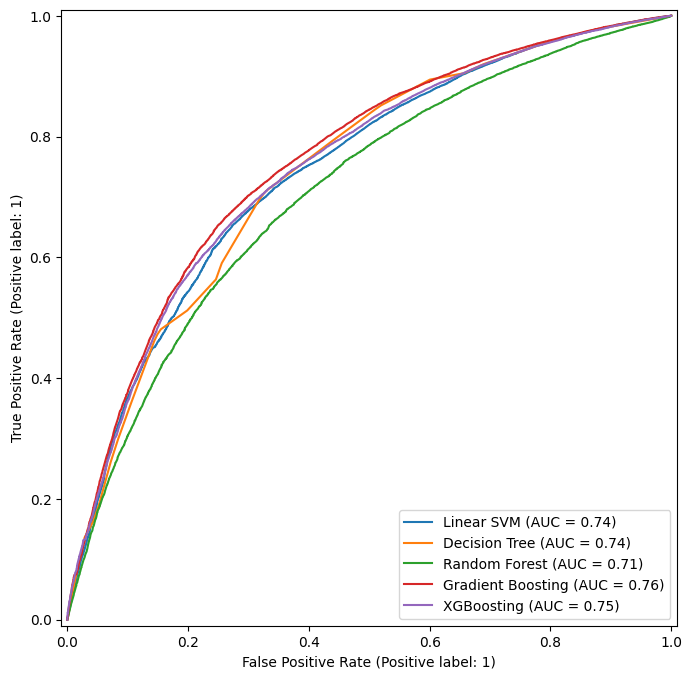

In [33]:
# xgboost weight
n_pos = sum(y_train == 1)
n_neg = sum(y_train == 0)
scale_pos_weight = n_neg / n_pos

# models
models = {
    "Linear SVM": LinearSVC(random_state=1312),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=1312),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=1312),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=1312),
    "XGBoosting": XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=1312, scale_pos_weight=scale_pos_weight)
}

all_results = []
plt.figure(figsize=(10, 8))  # ROC plot

# training
for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")
    model.fit(X_train, y_train)

    # predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # prob or score 
    if hasattr(model, "predict_proba"):
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_test_prob = model.predict_proba(X_test)[:, 1]
        response_method = "predict_proba"
    elif hasattr(model, "decision_function"):
        y_train_prob = model.decision_function(X_train)
        y_test_prob = model.decision_function(X_test)
        response_method = "decision_function"
    else:
        y_train_prob = None
        y_test_prob = None
        response_method = None

    # evaluate
    train_results = evaluate_model(y_train, y_train_pred, "Train", y_train_prob, model_name)
    test_results = evaluate_model(y_test, y_test_pred, "Test", y_test_prob, model_name)

    all_results.extend([train_results, test_results])

    # ROC
    if response_method is not None:
        RocCurveDisplay.from_estimator(
            model, X_test, y_test,
            name=model_name,
            response_method=response_method,
            ax=plt.gca()
        )
        
results_df = pd.DataFrame(all_results).set_index(["model", "dataset"])
print(results_df)

In [34]:
# considering the highest value of the ROC curve and the absence of significative overfitting, we select Gradient Boosting as our best model
best_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=1312)

# Training of the Selected Model on all the available labelled data to make Predictions

### Fit the model with all the data

In [35]:
df_final = snapshots

X_train_final = df_final.drop(columns=['churn', 'prediction_date', 'user.uid', 'order.uid_nunique'])
y_train_final = df_final['churn']

best_model.fit(X_train_final, y_train_final)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


### Creation of predictions_df: users with at least an order in the 2024/2025 season (from 30/11/2024 to 01/04/2025) to see how they could behave in the following season 2025/2026

In [36]:
# re-create 'full_orders' dataset
full_orders = orders_df.merge(order_agg_all, on='order.uid', how='left')
# remove non essential columns
full_orders = full_orders.drop(columns=['completed_items','cancelled_items','onhold_items','processing_items','discount_items','dynamic_pricing_items',
                                        'createdAtTime'])
# reset index 
full_orders.reset_index(inplace=True)
full_orders = full_orders.sort_values('createdAt').set_index('createdAt', drop=False)

In [37]:
# df
predictions_df = []

# fixed window
start_date = pd.Timestamp("2024-11-30") 
end_date = pd.Timestamp("2025-04-01")
orders_window = full_orders.loc[start_date:end_date]

# agg features
user_feat = orders_window.groupby('user.uid').agg({
    'order.uid': 'nunique',
    'total_amount':'sum',
    'completion_rate':'mean',
    'cancellation_rate':'mean',
    'onhold_rate':'mean',
    'discount_rate':'mean',
    'dynamic_rate':'mean',
    'pickup':['any','mean'],
    'pickupComplete':'mean',
    'paymentAttempts':['mean','max']
})
user_feat.columns = ['_'.join(col).strip() for col in user_feat.columns.values]
user_feat = user_feat.reset_index()

# normalized preferences
for col in ['paymentGateway','paymentBrand','source','tenant']:
    filtered = orders_window[orders_window[col] != 'none']

    counts = (orders_window.groupby('user.uid')[col]
              .value_counts(normalize=True)
              .unstack(fill_value=0)
              .reindex(columns=[c for c in filtered[col].unique() if c != 'none'], fill_value=0)
              .add_prefix(f"{col}_")
              .reset_index())
    user_feat = user_feat.merge(counts, on='user.uid', how='left')

# macro categories
macro_cols = [c for c in orders_window.columns if c.endswith('_spent')]
macro_sum = orders_window.groupby('user.uid')[macro_cols].sum().reset_index()
user_feat = user_feat.merge(macro_sum, on='user.uid', how='left')

# final dataset
predictions_df = user_feat.copy()
print("Dataset ready:", predictions_df.shape)

Dataset ready: (66149, 42)


In [38]:
predictions_df.columns

Index(['user.uid', 'order.uid_nunique', 'total_amount_sum',
       'completion_rate_mean', 'cancellation_rate_mean', 'onhold_rate_mean',
       'discount_rate_mean', 'dynamic_rate_mean', 'pickup_any', 'pickup_mean',
       'pickupComplete_mean', 'paymentAttempts_mean', 'paymentAttempts_max',
       'paymentGateway_stripe', 'paymentGateway_welfare',
       'paymentGateway_discount', 'paymentGateway_coupon',
       'paymentGateway_satispay', 'paymentBrand_visa',
       'paymentBrand_mastercard', 'paymentBrand_amex', 'paymentBrand_discover',
       'paymentBrand_diners', 'source_website', 'source_app',
       'tenant_snowit_esterno', 'tenant_snowit_welfare', 'tenant_snowit',
       'tenant_discovera', 'tenant_tribala', 'tenant_bikeit_welfare',
       'tenant_bikeit_esterno', 'tenant_tribala_esterno', 'bundle_spent',
       'experience_spent', 'food_spent', 'gift_promo_spent', 'hotel_spent',
       'rental_spent', 'services_spent', 'skipass_spent', 'transport_spent'],
      dtype='object')

In [39]:
predictions_df.isna().sum()

user.uid                   0
order.uid_nunique          0
total_amount_sum           0
completion_rate_mean       0
cancellation_rate_mean     0
onhold_rate_mean           0
discount_rate_mean         0
dynamic_rate_mean          0
pickup_any                 0
pickup_mean                0
pickupComplete_mean        0
paymentAttempts_mean       0
paymentAttempts_max        0
paymentGateway_stripe      0
paymentGateway_welfare     0
paymentGateway_discount    0
paymentGateway_coupon      0
paymentGateway_satispay    0
paymentBrand_visa          0
paymentBrand_mastercard    0
paymentBrand_amex          0
paymentBrand_discover      0
paymentBrand_diners        0
source_website             0
source_app                 0
tenant_snowit_esterno      0
tenant_snowit_welfare      0
tenant_snowit              0
tenant_discovera           0
tenant_tribala             0
tenant_bikeit_welfare      0
tenant_bikeit_esterno      0
tenant_tribala_esterno     0
bundle_spent               0
experience_spe

### Prediction

In [40]:
# removing useless
predictions_df = predictions_df.drop(columns=['order.uid_nunique'])

# features to be rescaled
monetary_features = [
    "total_amount_sum",
    "paymentAttempts_max"
] + [col for col in predictions_df.columns if col.endswith("_spent")]

# min-max scaling [0,1]
scaler = MinMaxScaler()
scaler.fit(X_train_final[monetary_features])
for col in monetary_features:
    if col in predictions_df.columns:
        predictions_df[[col]] = scaler.fit_transform(predictions_df[[col]])

In [41]:
model_features = best_model.feature_names_in_   
missing_cols = set(model_features) - set(predictions_df.columns)

if missing_cols:
    print(f"These columns are missing: {missing_cols}")
else:
    print("All necessary columns are here")

These columns are missing: {'tenant_bikeit', 'paymentGateway_scalapay', 'tenant_tribala_welfare', 'paymentBrand_unionpay'}


In [42]:
for col in missing_cols:
    predictions_df[col] = 0

In [43]:
# necessary columns
X_new = predictions_df[model_features]

# binary prediction
predictions_df['will_be_churn?'] = best_model.predict(X_new)

# probability prediction
predictions_df['churn_prob'] = best_model.predict_proba(X_new)[:,1]

# extract churners
churn_users = predictions_df.loc[predictions_df['will_be_churn?'] == 1, 'user.uid'].tolist()

print(f"Total clients analyzed: {X_new.shape[0]}")
print(f"Supposed churners: {len(churn_users)}")

Total clients analyzed: 66149
Supposed churners: 54023


# Save Churner dataset

In [44]:
churn_df = predictions_df[predictions_df['will_be_churn?'] == 1]
churn_df = churn_df[['user.uid', 'will_be_churn?', 'churn_prob']]
churn_df.head()

,user.uid,will_be_churn?,churn_prob
1,005dpt4a0puxgicccu6ixvlc9f,1,0.858443
2,00bcwo2xxxya7mdn6morwb9z83,1,0.754453
3,00bua0ypencroqp5mgcohofq2z,1,0.681696
4,00c2zutvhrg2wsots6dqti4acu,1,0.792132
5,00clfrqurmcwn0xdlnqcpricmi,1,0.776652


In [45]:
# project directory
project_dir = Path.cwd().parents[0]
project_dir

WindowsPath('c:/Users/davyt/Desktop/Bicocca/Marketing Analytics/unimib_snowit_project')

In [46]:
# 'models' folder
models_dir = project_dir / "models"
models_dir.mkdir(parents=True, exist_ok=True) 
models_dir

WindowsPath('c:/Users/davyt/Desktop/Bicocca/Marketing Analytics/unimib_snowit_project/models')

In [47]:
# saving
churn_df.to_csv(models_dir / "predicted_2025-2026_between_churn_df.csv", index=False)